In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf 
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns

In [2]:
# Date range selected according to the data available 
start = dt.datetime(2019, 7, 1)
end = dt.datetime(2024, 3, 1)

In [3]:
# Get CPI data
cpi = pdr.get_data_fred('CPIAUCSL', start, end)
cpi.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True) 
# Get Federal Funds Rate data
fed_funds_rate = pdr.get_data_fred('FEDFUNDS', start, end)

In [4]:
# Merge Macro Data
macro_data = pd.merge(cpi, fed_funds_rate, left_index=True, right_index=True, how='inner')
macro_data.head()

,CPI,FEDFUNDS
DATE,,
2019-07-01,255.802,2.40
2019-08-01,256.036,2.13
2019-09-01,256.430,2.04
2019-10-01,257.155,1.83
2019-11-01,257.879,1.55


In [5]:
# ETF (SPDR Fund)
tech = yf.download('XLK', start, end)
finance = yf.download('XLF', start, end)
indus = yf.download('XLI', start, end)
energy = yf.download('XLE', start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
ticker_list = ['tech', 'finance', 'indus', 'energy']

In [7]:
portfolio = {'tech':tech, 'finance':finance, 'indus':indus, 'energy':energy}

### Initial look through of the performance of the different industry

In [8]:
tech.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1175 entries, 2019-07-01 to 2024-02-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1175 non-null   float64
 1   High       1175 non-null   float64
 2   Low        1175 non-null   float64
 3   Close      1175 non-null   float64
 4   Adj Close  1175 non-null   float64
 5   Volume     1175 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 64.3 KB


In [9]:
# Understand overall trend 
tech['Close: 30 Mean'] = tech['Close'].rolling(window=30).mean()
finance['Close: 30 Mean'] = finance['Close'].rolling(window=30).mean()
indus['Close: 30 Mean'] = indus['Close'].rolling(window=30).mean()
energy['Close: 30 Mean'] = energy['Close'].rolling(window=30).mean()

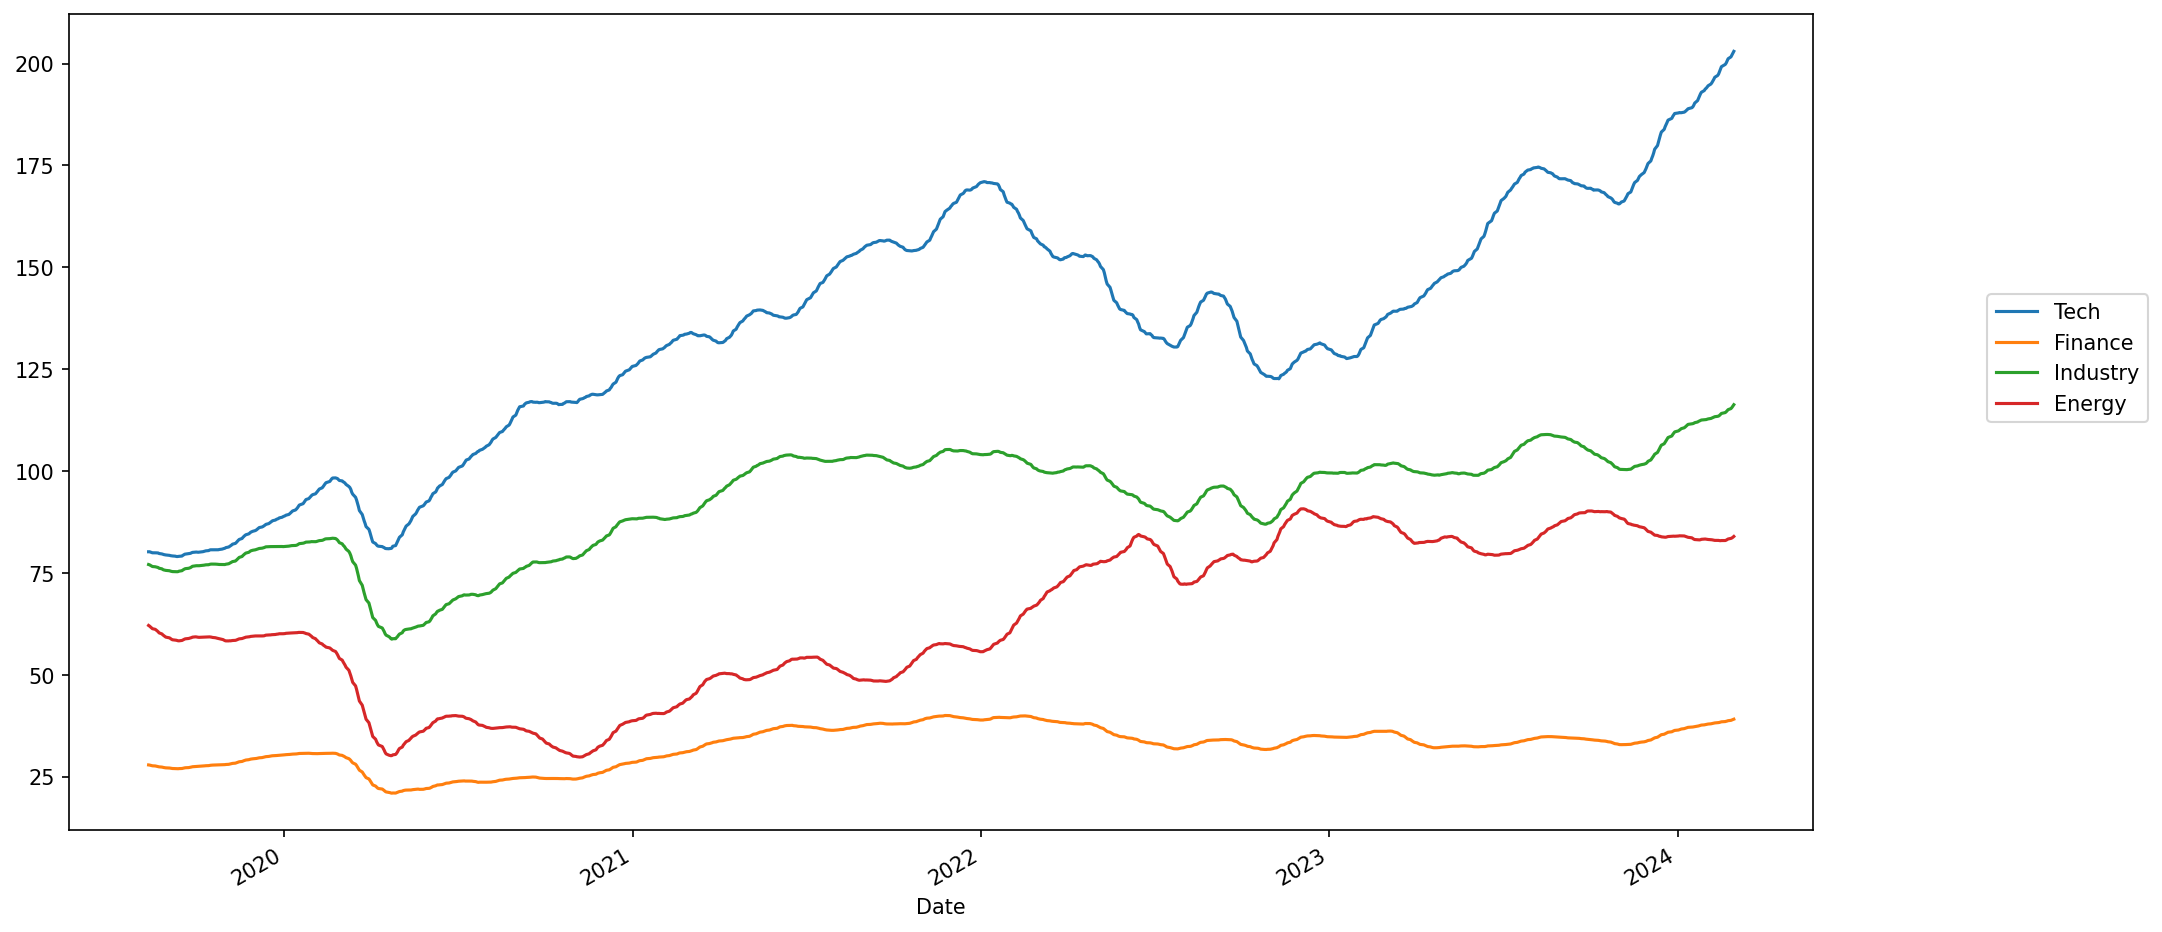

In [10]:
# Plot Trend Graph
fig,ax = plt.subplots(dpi=150, figsize=(15,8))
tech['Close: 30 Mean'].plot(ax=ax, label='Tech')
finance['Close: 30 Mean'].plot(ax=ax, label='Finance')
indus['Close: 30 Mean'].plot(ax=ax, label='Industry')
energy['Close: 30 Mean'].plot(ax=ax, label='Energy')
plt.legend(loc=(1.1,0.5))

In [11]:
# Function to calculate cumulative returns
def cum_10000(data):
    ret = data['Adj Close'].pct_change(1)[1:]
    cum_ret = (ret + 1).cumprod()
    ret_10000 = cum_ret*10000
    return ret_10000

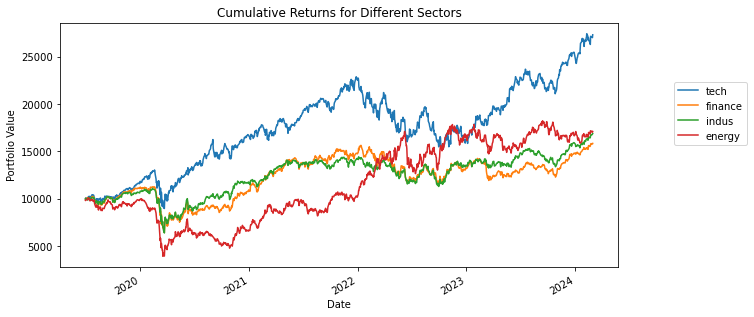

In [12]:
# Plot cumulative returns
for x, df in portfolio.items():
    cum_returns = cum_10000(df)
    cum_returns.plot(label=x, figsize=(10, 5))
    
plt.title('Cumulative Returns for Different Sectors')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(loc=(1.1,0.5))

In [13]:
# Function to calculateSharpe Ratio
def get_sharpe_ratio(data, rfr=0.04):
    mean_return = data['Adj Close'].pct_change(1).mean()
    std = data['Adj Close'].pct_change(1).std()
    sharpe_ratio = (mean_return - rfr) / std
    return (252**0.5) * sharpe_ratio

In [14]:
for x,df in portfolio.items():
    print(f"{x} Annualized sharpe ration is: {get_sharpe_ratio(df)}")

tech Annualized sharpe ration is: -35.28615405575649
finance Annualized sharpe ration is: -36.76705320669189
indus Annualized sharpe ration is: -41.75284287181855
energy Annualized sharpe ration is: -26.409040620695283


While sectors like technology and energy have demonstrated strong performance in recent years, the presence of a negative Sharpe ratio for these ETFs implies that, when considering both risk and the prevailing risk-free rate, the returns may not have sufficiently rewarded investors during the analyzed period. This negative Sharpe ratio can be attributed to high inflation and the resulting high risk-free rate. High inflation erodes purchasing power and increases costs for companies, impacting profit margins. To combat inflation, central banks often raise interest rates, which increases the risk-free rate and the cost of borrowing, potentially slowing economic growth. These factors combined can lead to higher volatility and lower risk-adjusted returns, despite the apparent strong performance of the stocks. Delving into specific companies within each industry could offer deeper insights, as ETF compositions vary, and numerous factors uniquely influence individual companies' performances within these sectors.

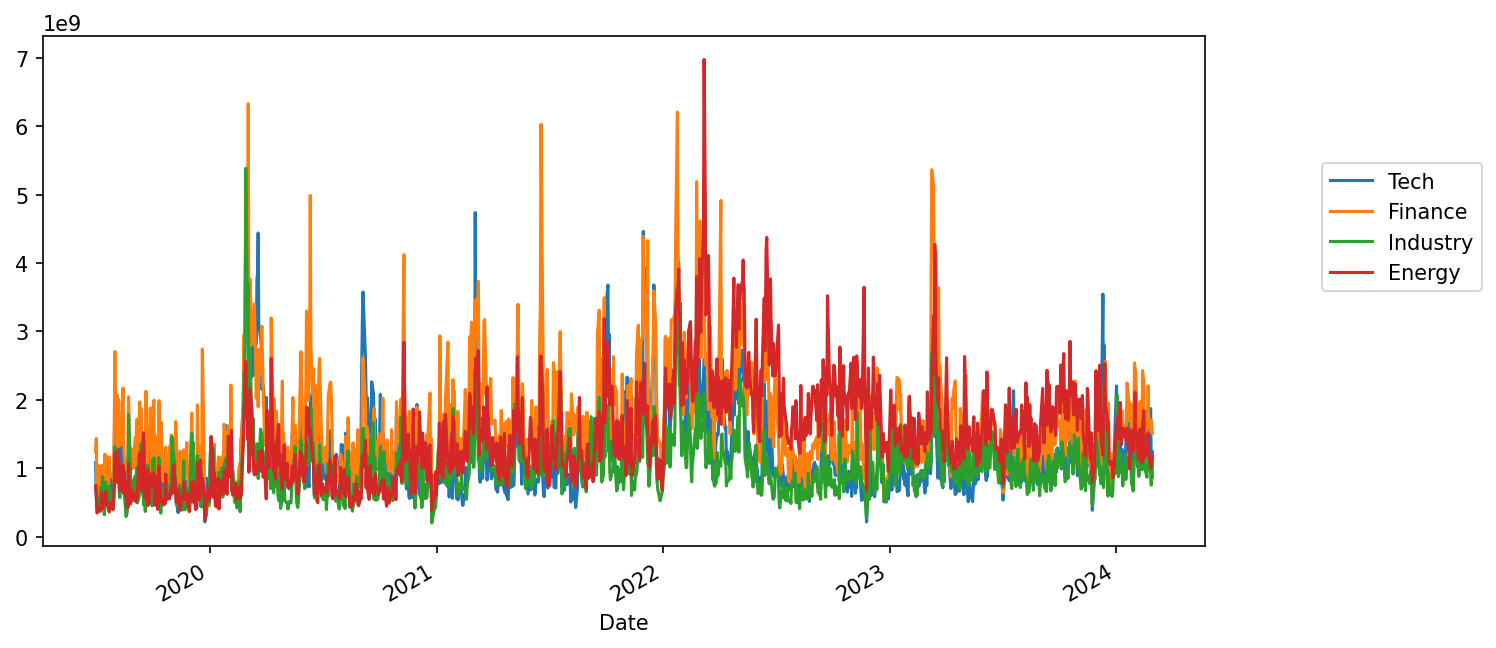

In [15]:
# Volume and Stock close price
fig,ax = plt.subplots(dpi=150,figsize=(10,5))
(tech['Volume']*tech['Adj Close']).plot(ax=ax,label='Tech')
(finance['Volume']*finance['Adj Close']).plot(ax=ax,label='Finance')
(indus['Volume']*indus['Adj Close']).plot(ax=ax,label='Industry')
(energy['Volume']*energy['Adj Close']).plot(ax=ax,label='Energy')
plt.legend(loc=(1.1,0.5))

In [16]:
(energy['Volume']*energy['Adj Close']).max()

6975534391.174316

In [17]:
(energy['Volume']*energy['Adj Close']).idxmax()

Timestamp('2022-03-08 00:00:00')

The energy ETF had the highest trading volume, which can be attributed to rising oil prices. On March 1st, President Joe Biden announced a ban on imports of Russian energy due to the Russia-Ukraine war. The UK also declared its intention to phase out Russian energy products by the end of the year. This geopolitical tension significantly impacted the energy markets. Moreover, Bloomberg, a widely-read source among stock traders, published an article titled "Oil Extends Gains With US and UK Banning Russian Imports," further influencing trading activity in the energy sector.

## Correlation

In [18]:
for sector in portfolio:
    portfolio[sector] = portfolio[sector]['Adj Close'].resample('M').mean()

# Change datetime index to the first day of each month
for sector in portfolio:
    portfolio[sector].index = portfolio[sector].index + pd.offsets.MonthBegin(1)

In [19]:
portfolio_df = pd.concat(portfolio.values(), axis=1, keys=portfolio.keys())

# Display the combined DataFrame
print(portfolio_df.head())

                 tech    finance      indus     energy
Date                                                  
2019-08-01  77.262667  25.574554  71.664864  49.458393
2019-09-01  74.871950  24.266298  68.786741  45.385456
2019-10-01  77.130183  25.424094  71.889788  47.446866
2019-11-01  77.840951  25.492756  71.236741  45.703820
2019-12-01  82.946081  27.169400  75.693953  47.333134


In [20]:
# Merge data
data = portfolio_df.merge(macro_data, left_index=True, right_index=True, how='inner')
data.head()

,tech,finance,indus,energy,CPI,FEDFUNDS
2019-08-01,77.262667,25.574554,71.664864,49.458393,256.036,2.13
2019-09-01,74.871950,24.266298,68.786741,45.385456,256.430,2.04
2019-10-01,77.130183,25.424094,71.889788,47.446866,257.155,1.83
2019-11-01,77.840951,25.492756,71.236741,45.703820,257.879,1.55
2019-12-01,82.946081,27.169400,75.693953,47.333134,258.630,1.55


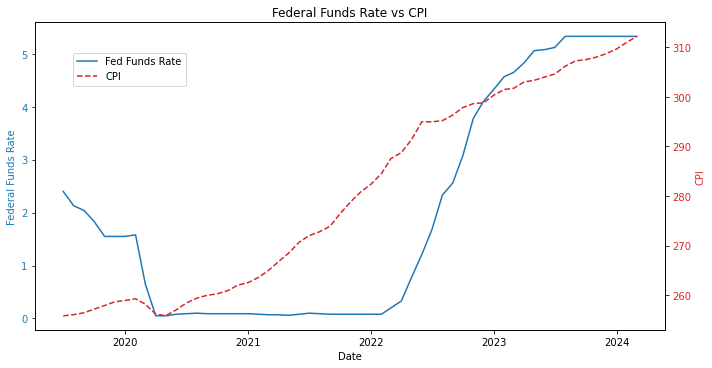

In [21]:
# Plot Federal Funds Rate vs CPI
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('Federal Funds Rate', color='tab:blue')

# Adjust the column name to match your merged DataFrame
ax1.plot(macro_data.index, macro_data['FEDFUNDS'], color='tab:blue', label='Fed Funds Rate')

ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for CPI
ax2 = ax1.twinx()
ax2.set_ylabel('CPI', color='tab:red')
ax2.plot(macro_data.index, macro_data['CPI'], color='tab:red', linestyle='--', label='CPI')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Federal Funds Rate vs CPI')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

In [22]:
# Compute correlation matrix
correlation_matrix = data.corr()

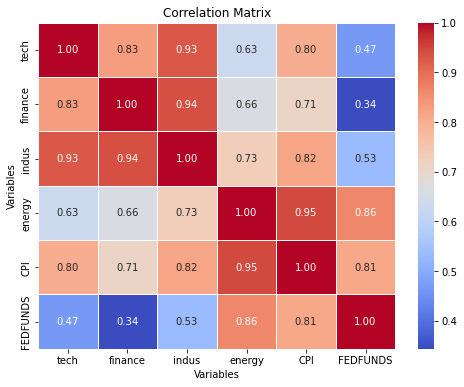

In [23]:
# Plot correlation matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

The correlation analysis reveals strong interconnections between different industry sectors, with tech, finance, and industrial sectors exhibiting particularly high correlations (0.83 to 0.94). This suggests that these sectors tend to move in tandem, likely responding similarly to economic conditions and market sentiments. The energy sector, while moderately correlated with tech (0.63), finance (0.66), and industrial (0.73), shows very high correlations with the Consumer Price Index (CPI) (0.95) and the Federal Funds Rate (0.86). This underscores the significant influence of energy prices on overall inflation and interest rate policies. Additionally, CPI is highly correlated with all sectors, especially energy, reflecting its central role in driving inflation, which in turn heavily influences the Fed's rate decisions. The Federal Funds Rate itself shows moderate correlations with tech (0.47), finance (0.34), and industrial (0.53), but a strong correlation with CPI (0.81), highlighting the Fed's focus on inflation control, particularly driven by energy costs.